<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-files" data-toc-modified-id="Load-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load files</a></span></li><li><span><a href="#Adding-New-Features" data-toc-modified-id="Adding-New-Features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Adding New Features</a></span></li></ul></div>

In [609]:
from IPython.core.display import display, HTML, Markdown as md
display(HTML("""<style>.container { width:90% !important; } p, ul {max-width:␣
,→40em;} .rendered_html table { margin-left: 0; } .output_subarea.output_png {␣
,→display: flex; justify-content: center;}</style>"""))

## Imports

In [ ]:
import pandas as pd
import numpy as np
import os

In [611]:
import difflib
import re

In [2]:
import spacy

In [12]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [13]:
from spacy.matcher import Matcher

In [610]:
import en_core_web_lg
nlp_lg = spacy.load('en_core_web_lg')

In [ ]:
from spacy import displacy

In [289]:
import networkx as nx

## Load files

In [545]:
oneDocRelationships = pd.read_csv('oneDocRelationships.csv', index_col=0, dtype={'Tagged_Relationship': np.int8})
col_to_downcast=[col for col in oneDocRelationships.columns if oneDocRelationships[col].dtype==int]
oneDocRelationships[col_to_downcast]=oneDocRelationships[col_to_downcast].apply(pd.to_numeric, downcast='integer')

In [499]:
allPossibleRelationships = pd.read_csv('allPossibleRelationships.csv', index_col=0, dtype={'Tagged_Relationship': 'Int8'})
col_to_downcast=[col for col in allPossibleRelationships.columns if allPossibleRelationships[col].dtype==int]
allPossibleRelationships[col_to_downcast]=allPossibleRelationships[col_to_downcast].apply(pd.to_numeric, downcast='integer')

In [612]:
filename = oneDocRelationships.Document.unique()[0]+'.txt'

In [613]:
file = open('FraserSet/BodyOnly/Clean/'+filename)
document = file.read()
file.close()
doc = nlp_lg(document)

In [546]:
oneDocRelationships.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7590 entries, 0 to 7589
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Species                 7590 non-null   object 
 1   Start_Token_Species     7590 non-null   int16  
 2   End_Token_Species       7590 non-null   int16  
 3   Start_Index_Species     7590 non-null   int32  
 4   End_Index_Species       7590 non-null   int32  
 5   Sentence_Species        7590 non-null   object 
 6   inAbstract300_Species   7590 non-null   int8   
 7   inAbstract500_Species   7590 non-null   int8   
 8   max_TFISF_Species       7590 non-null   float64
 9   Sent_Start_Species      7590 non-null   int8   
 10  Document                7590 non-null   object 
 11  Location                7590 non-null   object 
 12  Start_Token_Location    7590 non-null   int16  
 13  End_Token_Location      7590 non-null   int16  
 14  Start_Index_Location    7590 non-null   

In [500]:
allPossibleRelationships.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21418 entries, 0 to 21417
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Species                 21418 non-null  object 
 1   Start_Token_Species     21418 non-null  int16  
 2   End_Token_Species       21418 non-null  int16  
 3   Start_Index_Species     21418 non-null  int32  
 4   End_Index_Species       21418 non-null  int32  
 5   Sentence_Species        21418 non-null  object 
 6   inAbstract300_Species   21418 non-null  int8   
 7   inAbstract500_Species   21418 non-null  int8   
 8   max_TFISF_Species       21418 non-null  float64
 9   Sent_Start_Species      21418 non-null  int8   
 10  Document                21418 non-null  object 
 11  Location                21418 non-null  object 
 12  Start_Token_Location    21418 non-null  int16  
 13  End_Token_Location      21418 non-null  int16  
 14  Start_Index_Location    21418 non-null

## Adding New Features

In [544]:
def AddRelationshipFeatures(df, doc):
#     df['Same_Sentence']= df['Sentence_Species'] == df['Sentence_Location']
    df['Same_Sentence']= [1 if doc[df.loc[X]['Start_Token_Species']].sent == 
                                   doc[df.loc[X]['Start_Token_Location']].sent
                                       else 0
                                       for X in df.index]
    df.Same_Sentence=df.Same_Sentence.astype('int8')
    df['Num_Tokens_Between'] = [max(df.loc[X]['Start_Token_Species'], 
                                                 df.loc[X]['Start_Token_Location']) 
                                             - min(df.loc[X]['End_Token_Species'], 
                                                   df.loc[X]['End_Token_Location'])
                                             for X in df.index]
    df['Num_Words_Between'] = [len([token for token in doc[min(df.loc[X]['End_Token_Species'], 
                                                                             df.loc[X]['End_Token_Location']):
                                                                         max(df.loc[X]['Start_Token_Species'], 
                                                                             df.loc[X]['Start_Token_Location'])]
                                                  if token.is_alpha])
                                             for X in df.index]
    df['Num_Verbs_Between'] = [len([token for token in doc[min(df.loc[X]['End_Token_Species'], 
                                                                             df.loc[X]['End_Token_Location']):
                                                                         max(df.loc[X]['Start_Token_Species'], 
                                                                             df.loc[X]['Start_Token_Location'])]
                                                  if token.pos_ =='VERB'])
                                             for X in df.index]
    df['Num_Nouns_Between'] = [len([token for token in doc[min(df.loc[X]['End_Token_Species'], 
                                                                             df.loc[X]['End_Token_Location']):
                                                                         max(df.loc[X]['Start_Token_Species'], 
                                                                             df.loc[X]['Start_Token_Location'])]
                                                  if token.pos_ =='NOUN'])
                                             for X in df.index]
    df['Num_Preps_Between'] = [len([token for token in doc[min(df.loc[X]['End_Token_Species'], 
                                                                             df.loc[X]['End_Token_Location']):
                                                                         max(df.loc[X]['Start_Token_Species'], 
                                                                             df.loc[X]['Start_Token_Location'])]
                                                  if token.pos_ =='ADP'])
                                             for X in df.index]

    df['Preposition_Between'] = df['Num_Preps_Between']>0

    df['Preposition_Between'] = (df['Num_Preps_Between']>0).astype('int8')

    df['Dependency_Steps'] = countDependencySteps(zip(df.Start_Token_Species,
                                                                      df.End_Token_Species,
                                                                      df.Start_Token_Location,
                                                                      df.End_Token_Location,
                                                                      df.Same_Sentence), doc)
    return df

In [549]:
def countDependencySteps (tokens, doc):
    results=[]
    for start_token_spec, end_token_spec, start_token_loc, end_token_loc, samesent  in tokens:
#         print(start_token_spec, end_token_spec, start_token_loc, end_token_loc, samesent)
        if samesent == 0:
            results.append(999)
        else:
#             print(start_token_spec, end_token_spec, start_token_loc, end_token_loc, samesent)
            sentence = doc[start_token_spec].sent

            edges = []
            for token in sentence:
                for child in token.children:
                    edges.append(('{0}'.format(token.lower_),
                                  '{0}'.format(child.lower_)))
            graph = nx.Graph(edges)

            # Get the length and path
            minpath=999

            for i in range(start_token_spec, end_token_spec):
                entity1 = doc[i].text.lower()
                for j in range(start_token_loc, end_token_loc):
                    entity2 = doc[j].text.lower()
                    if nx.has_path(graph, source=entity1, target=entity2) == True:
                        pathlength = nx.shortest_path_length(graph, source=entity1, target=entity2)
                    else:
                        pathlength = 999
            #         minpath = min(minpath, pathlength)
                    if pathlength<minpath:
                        minpath=pathlength
#                         ent1 = entity1
#                         ent1tkn = i
#                         ent2 = entity2
#                         ent2tkn = j
        #     print(minpath)
#             shortest_path = nx.shortest_path(graph, source=ent1, target=ent2)
        #     print(shortest_path)
            results.append(minpath)
    return results

In [552]:
def addExtraFeaturestoAll(df):
    new_df = pd.DataFrame()
    for source in df.Document.unique():
#         print(source)
        df_sub=df[df.Document==source].copy()
        filename = source +'.txt'
        file = open('FraserSet/BodyOnly/Clean/'+filename)
        document = file.read()
        file.close()
        doc = nlp_lg(document)
        df_sub=AddRelationshipFeatures(df_sub, doc)
        new_df=pd.concat([new_df, df_sub])

        new_df.reset_index(drop=True, inplace=True)
        
    return new_df

In [506]:
allPossibleRelationships.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21418 entries, 0 to 21417
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Species                 21418 non-null  object 
 1   Start_Token_Species     21418 non-null  int16  
 2   End_Token_Species       21418 non-null  int16  
 3   Start_Index_Species     21418 non-null  int32  
 4   End_Index_Species       21418 non-null  int32  
 5   Sentence_Species        21418 non-null  object 
 6   inAbstract300_Species   21418 non-null  int8   
 7   inAbstract500_Species   21418 non-null  int8   
 8   max_TFISF_Species       21418 non-null  float64
 9   Sent_Start_Species      21418 non-null  int8   
 10  Document                21418 non-null  object 
 11  Location                21418 non-null  object 
 12  Start_Token_Location    21418 non-null  int16  
 13  End_Token_Location      21418 non-null  int16  
 14  Start_Index_Location    21418 non-null

In [553]:
allPossibleRelationships = addExtraFeaturestoAll(allPossibleRelationships)

In [554]:
allPossibleRelationships.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21418 entries, 0 to 21417
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Species                 21418 non-null  object 
 1   Start_Token_Species     21418 non-null  int16  
 2   End_Token_Species       21418 non-null  int16  
 3   Start_Index_Species     21418 non-null  int32  
 4   End_Index_Species       21418 non-null  int32  
 5   Sentence_Species        21418 non-null  object 
 6   inAbstract300_Species   21418 non-null  int8   
 7   inAbstract500_Species   21418 non-null  int8   
 8   max_TFISF_Species       21418 non-null  float64
 9   Sent_Start_Species      21418 non-null  int8   
 10  Document                21418 non-null  object 
 11  Location                21418 non-null  object 
 12  Start_Token_Location    21418 non-null  int16  
 13  End_Token_Location      21418 non-null  int16  
 14  Start_Index_Location    21418 non-null

In [606]:
allPossibleRelationships.to_csv('workingDataset.csv')

In [142]:
def textToBOW ():
    BOW ={}
    length = 0
    for token in doc:
        if token.is_alpha:
            length +=1
            if token.text in BOW:
                BOW[token.text]+=1
            if token.text not in BOW:
                BOW[token.text] = 1
    print (length)
    for key in BOW.keys():
        BOW[key] = BOW[key]/length
    return BOW

In [286]:
displacy.render(doc[1075].sent, style='dep')

In [143]:
BOW.keys()

dict_keys(['text'])

In [144]:
bagofwords = textToBOW()

6622


In [145]:
bagofwords

{'Summer': 0.00015101177891875566,
 'activity': 0.008758683177287828,
 'patterns': 0.0006040471156750226,
 'for': 0.017819389912413167,
 'mosses': 0.0040773180308064025,
 'and': 0.037450921171851406,
 'lichens': 0.005889459377831471,
 'in': 0.020688613711869527,
 'Maritime': 0.0003020235578375113,
 'Antarctica': 0.0028692237994563576,
 'BURKHARD': 0.00015101177891875566,
 'ALLAN': 0.00015101177891875566,
 'ANA': 0.00015101177891875566,
 'ROMAN': 0.00015101177891875566,
 'LEOPOLDO': 0.00015101177891875566,
 'Institute': 0.00015101177891875566,
 'Science': 0.00015101177891875566,
 'Mathematics': 0.00015101177891875566,
 'Education': 0.00015101177891875566,
 'IPN': 0.00015101177891875566,
 'Kiel': 0.00015101177891875566,
 'Germany': 0.0003020235578375113,
 'Sciences': 0.00015101177891875566,
 'University': 0.0003020235578375113,
 'of': 0.028390214436726065,
 'Waikato': 0.00015101177891875566,
 'Private': 0.00015101177891875566,
 'Bag': 0.00015101177891875566,
 'Hamilton': 0.00015101177891

In [151]:
bagofwords[doc[1083].text]

0.001812141347025068

In [160]:
count = len([1 for sent in doc.sents if doc[1083].text in str(sent)])
count

12

In [214]:
doc[6597]

Umbilicaria

In [71]:
oneDocRelationships['Pairing_in']

In [113]:
oneDocRelationships['Species_in_Abstract']=[speciesAppearinAbstract(X) for X in oneDocRelationships.index]

In [53]:
AbstractToken

86

In [ ]:
oneDocRelationships['Species_in_Abstract']

In [49]:
if len(matches) >0:
    AbstractToken = matches[0][1]

[(18048708775278122796, 86, 87)]

In [187]:
doc[6553]

for

In [40]:
matches

[]

In [189]:
oneDocRelationships.head()

,Species,Start_Token_Species,End_Token_Species,Start_Index_Species,End_Index_Species,Document,Location,Start_Token_Location,End_Token_Location,Start_Index_Location,End_Index_Location,Tagged_Relationship,Species_in_Abstract,Location_in_Abstract
0,Umbilicaria aprina Nyl.,1075,1079,5800,5823,summer-activity-patterns-for-mosses-and-lichen...,Antarctica,9,10,60,70,0,0,1
1,Umbilicaria aprina Nyl.,1075,1079,5800,5823,summer-activity-patterns-for-mosses-and-lichen...,Kiel,38,39,235,239,0,0,0
2,Umbilicaria aprina Nyl.,1075,1079,5800,5823,summer-activity-patterns-for-mosses-and-lichen...,Germany,40,41,241,248,0,0,0
3,Umbilicaria aprina Nyl.,1075,1079,5800,5823,summer-activity-patterns-for-mosses-and-lichen...,Hamilton,52,53,312,320,0,0,0
4,Umbilicaria aprina Nyl.,1075,1079,5800,5823,summer-activity-patterns-for-mosses-and-lichen...,New Zealand,54,56,322,333,0,0,0


In [24]:
oneDocRelationships.Sent_Start_Location.unique()

array([0, 1])

In [227]:
oneDocRelationships[oneDocRelationships.Tagged_Relationship==True]

,Species,Start_Token_Species,End_Token_Species,Start_Index_Species,End_Index_Species,Document,Location,Start_Token_Location,End_Token_Location,Start_Index_Location,End_Index_Location,Tagged_Relationship,max_TFISF_Species,max_TFISF_Location
42,Umbilicaria aprina Nyl.,1075,1079,5800,5823,summer-activity-patterns-for-mosses-and-lichen...,Dry Valleys,1082,1084,5832,5843,1,5.814131,3.329224
43,Umbilicaria aprina Nyl.,1075,1079,5800,5823,summer-activity-patterns-for-mosses-and-lichen...,Botany Bay,1099,1101,5902,5912,1,5.814131,3.249181
182,Usnea aurantiaco-atra,1118,1122,5960,5981,summer-activity-patterns-for-mosses-and-lichen...,Livingston Island,1128,1130,5998,6015,1,4.715518,2.412933
338,Deschampsia antarctica,1941,1943,10374,10396,summer-activity-patterns-for-mosses-and-lichen...,South Bay,1895,1897,10160,10169,1,5.814131,4.022371
476,Colobanthus quitensis,1946,1948,10407,10428,summer-activity-patterns-for-mosses-and-lichen...,South Bay,1895,1897,10160,10169,1,5.814131,4.022371
614,Brachythecium austrosalebrosum,1996,1998,10668,10698,summer-activity-patterns-for-mosses-and-lichen...,South Bay,1895,1897,10160,10169,1,4.204693,4.022371
752,Pohlia nutans,2007,2009,10720,10733,summer-activity-patterns-for-mosses-and-lichen...,South Bay,1895,1897,10160,10169,1,5.814131,4.022371
890,Bryum pseudotriquetrum,2016,2018,10750,10772,summer-activity-patterns-for-mosses-and-lichen...,South Bay,1895,1897,10160,10169,1,4.715518,4.022371
1028,Sanionia uncinata,2030,2032,10811,10828,summer-activity-patterns-for-mosses-and-lichen...,South Bay,1895,1897,10160,10169,1,5.814131,4.022371
1166,Usnea spp.,2053,2056,10931,10941,summer-activity-patterns-for-mosses-and-lichen...,South Bay,1895,1897,10160,10169,1,11.628261,4.022371


In [204]:
oneDocRelationships.Document.unique()

array(['summer-activity-patterns-for-mosses-and-lichens-in-maritime-antarctica'],
      dtype=object)

In [232]:
doc[6468].sent

It is difficult to calculate mean activity for the single lichen species, Umbilicaria aprina, monitored at Botany Bay (Schroeter et al.

In [212]:
doc[6559].right_edge

Caloplaca

In [206]:
doc[1063].is_sent_start

In [615]:
sentence = doc[1065].sent
sentence

Annual activity (% of total time) ranged from 0.2% (Umbilicaria aprina Nyl.) in the Dry Valleys (Raggio et al. 2016) through 4.6% for the same species at Botany Bay (77°00'S)

In [625]:
options = {"compact": False, "distance": 110}
displacy.render(sentence, style="dep", jupyter=True, options=options)

In [573]:
cols_of_interest = ['inAbstract300_Species', 'inAbstract500_Species', 'max_TFISF_Species', 'Sent_Start_Species',
                    'inAbstract300_Location', 'inAbstract500_Location', 'max_TFISF_Location', 
                    'Sent_Start_Location', 'Tagged_Relationship', 'Same_Sentence', 'Num_Tokens_Between',
                     'Num_Words_Between', 'Num_Verbs_Between', 'Num_Nouns_Between', 'Num_Preps_Between',
                     'Preposition_Between', 'Dependency_Steps']

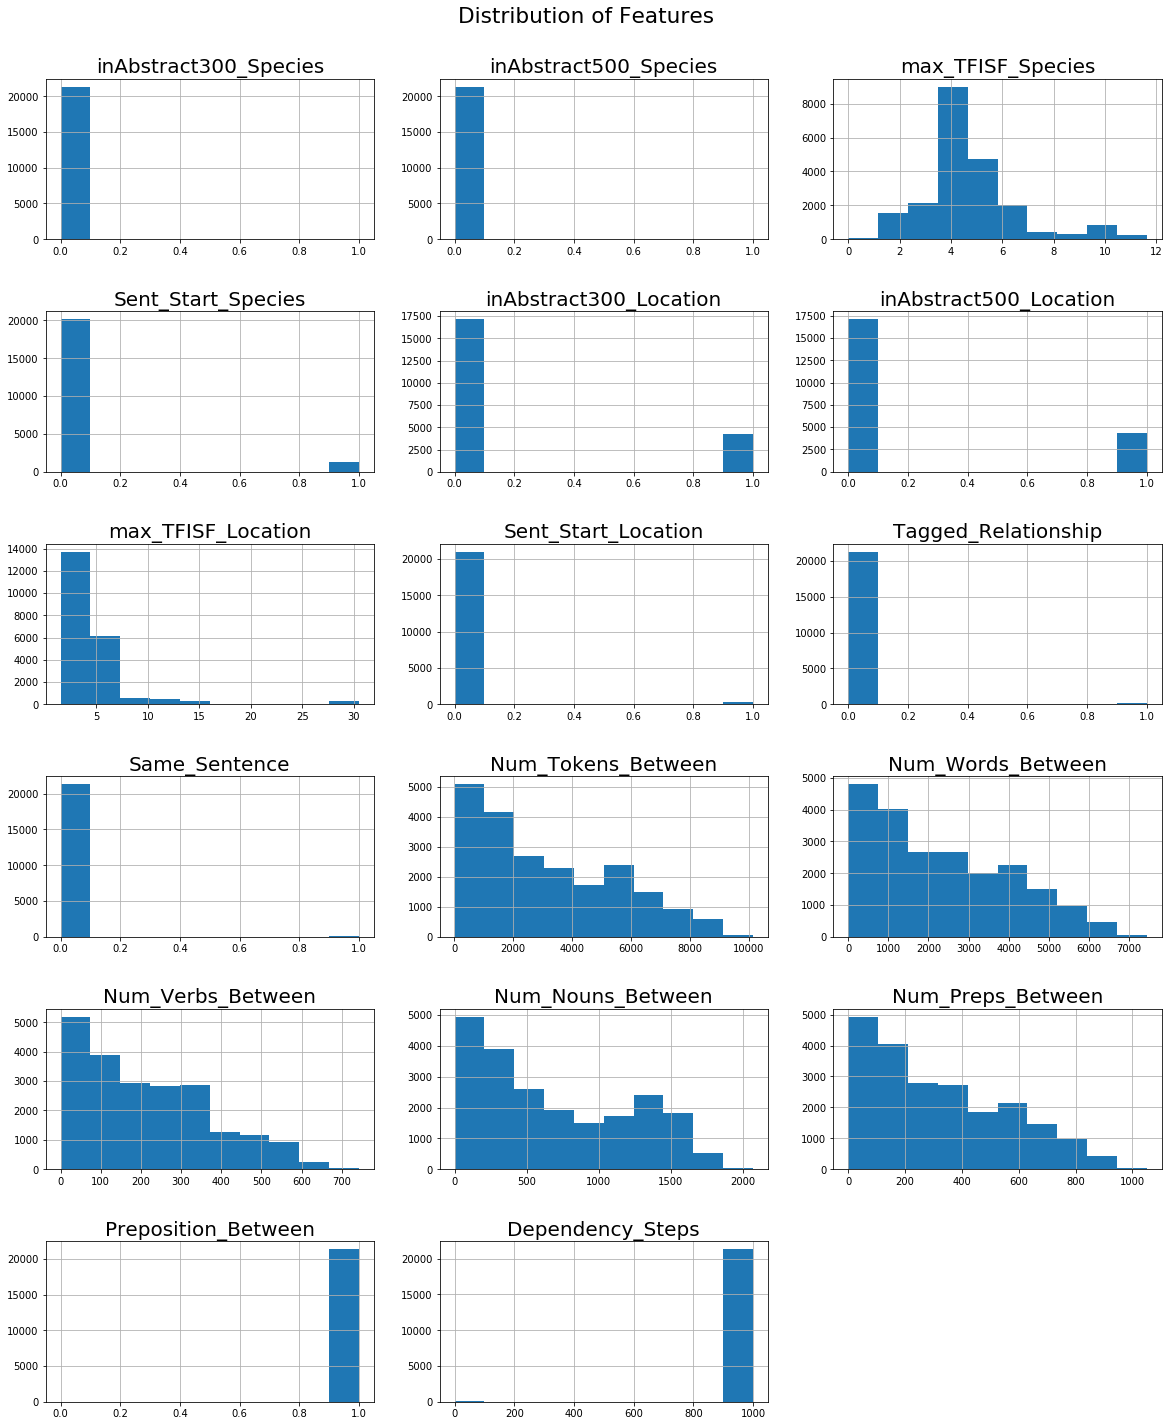

In [587]:
plt.figure(figsize=(20,50))
i=1
for col in cols_of_interest: #df['Site'].unique():
    ax = plt.subplot(12,3,i)
    allPossibleRelationships[col].hist()
    ax.set_title(col)
    i += 1
plt.subplots_adjust(hspace=.45)
plt.suptitle("Distribution of Features", y=0.9)
plt.show()  

In [590]:
possible_transformations = ['max_TFISF_Species', 'max_TFISF_Location', 'Num_Tokens_Between',
                            'Num_Words_Between', 'Num_Verbs_Between',  'Num_Nouns_Between', 'Num_Preps_Between']

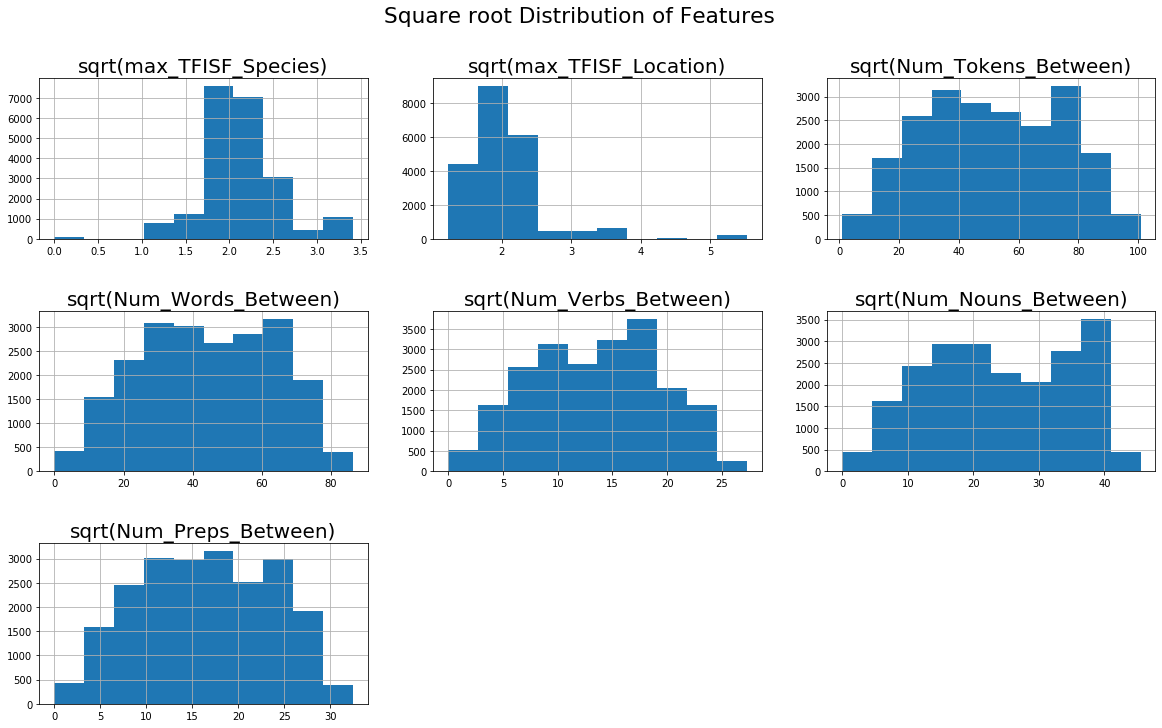

In [592]:
plt.figure(figsize=(20,50))
i=1
for col in possible_transformations: #df['Site'].unique():
    ax = plt.subplot(12,3,i)
    np.sqrt(allPossibleRelationships[col]).hist()
    ax.set_title('sqrt('+col+')')
    i += 1
plt.subplots_adjust(hspace=.45)
plt.suptitle("Square root Distribution of Features", y=0.9)
plt.show()  

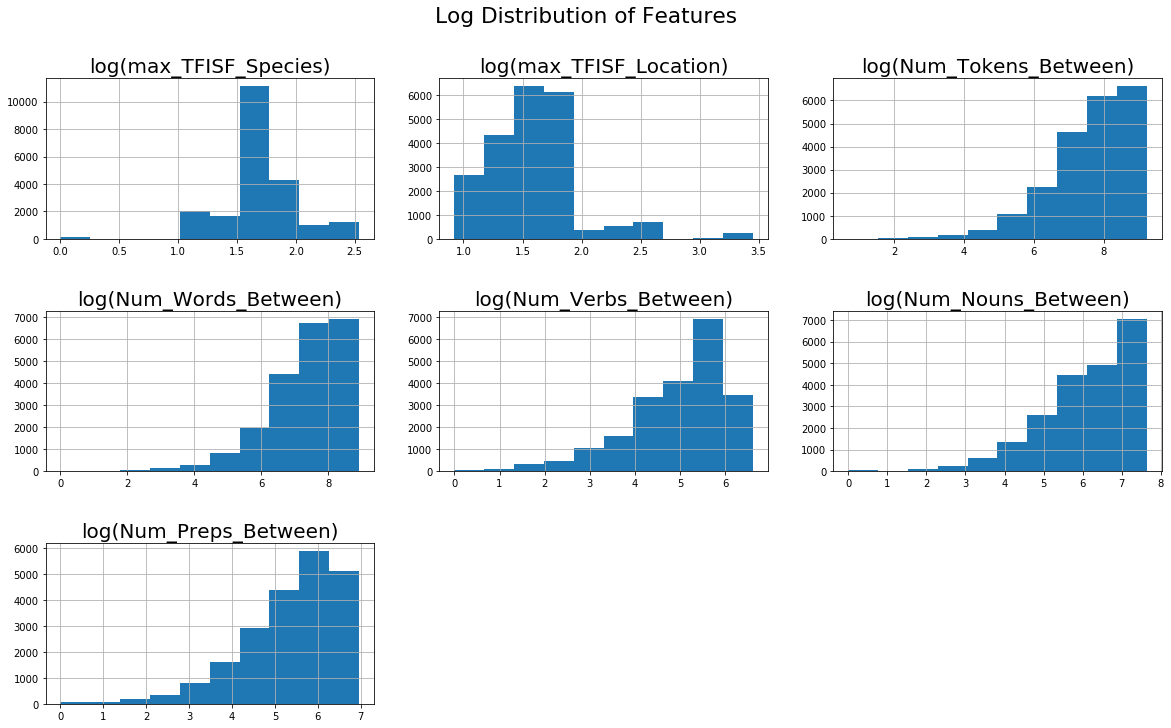

In [596]:
plt.figure(figsize=(20,50))
i=1
for col in possible_transformations: #df['Site'].unique():
    ax = plt.subplot(12,3,i)
    np.log(allPossibleRelationships[col]+1).hist()
    ax.set_title('log('+col+')')
    i += 1
plt.subplots_adjust(hspace=.45)
plt.suptitle("Log Distribution of Features", y=0.9)
plt.show()  

In [595]:
for col in possible_transformations:
    print (col, allPossibleRelationships[col].min(),allPossibleRelationships[col].max())

max_TFISF_Species 0.0 11.628261063650134
max_TFISF_Location 1.5163474893680884 30.50703085597627
Num_Tokens_Between 1 10147
Num_Words_Between 0 7450
Num_Verbs_Between 0 743
Num_Nouns_Between 0 2071
Num_Preps_Between 0 1051


In [557]:
import matplotlib.pyplot as plt

In [558]:
from pylab import rcParams

%matplotlib inline
# rcParams['figure.figsize'] = 10, 7

# %matplotlib inline
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18

In [602]:
for col in possible_transformations:
    name = 'sqrt_'+col
    allPossibleRelationships[name]=np.sqrt(allPossibleRelationships[col])

In [603]:
for col in ['max_TFISF_Species', 'max_TFISF_Location', 'Num_Verbs_Between']:
    name = 'log_'+col
    allPossibleRelationships[name]=np.log(allPossibleRelationships[col]+1)

In [604]:
allPossibleRelationships.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21418 entries, 0 to 21417
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Species                  21418 non-null  object 
 1   Start_Token_Species      21418 non-null  int16  
 2   End_Token_Species        21418 non-null  int16  
 3   Start_Index_Species      21418 non-null  int32  
 4   End_Index_Species        21418 non-null  int32  
 5   Sentence_Species         21418 non-null  object 
 6   inAbstract300_Species    21418 non-null  int8   
 7   inAbstract500_Species    21418 non-null  int8   
 8   max_TFISF_Species        21418 non-null  float64
 9   Sent_Start_Species       21418 non-null  int8   
 10  Document                 21418 non-null  object 
 11  Location                 21418 non-null  object 
 12  Start_Token_Location     21418 non-null  int16  
 13  End_Token_Location       21418 non-null  int16  
 14  Start_Index_Location  